In [567]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import torch
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
import matplotlib
matplotlib.rcParams.update({'font.size': 24, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


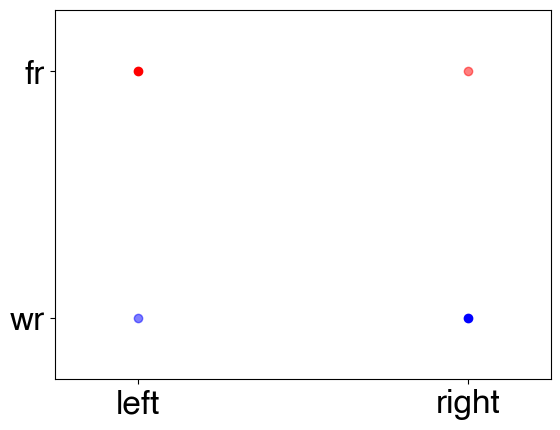

In [569]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

fig = plot_task_rep(X, y)

In [594]:
n_epochs = 5000
dim_input = 2
dim_hidden = 500
dim_output = 1

lr = 2e-3
# Initialization scale
# w1_inits = [0.001,0.01,0.1,0.5]
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

init_models = []
trained_models = []

# Training
for w_i, w1_init in enumerate(w1_inits):
    # Model instantiation
    dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    init_models.append(copy.deepcopy(dlnn_model))

    _, _, _ = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
    trained_models.append(dlnn_model)

In [595]:
rich_models = [init_models[0], trained_models[0]]
lazy_models = [init_models[-1], trained_models[-1]]

X = torch.tensor([x1, x2]).T
y = torch.tensor(y_np).unsqueeze(1)

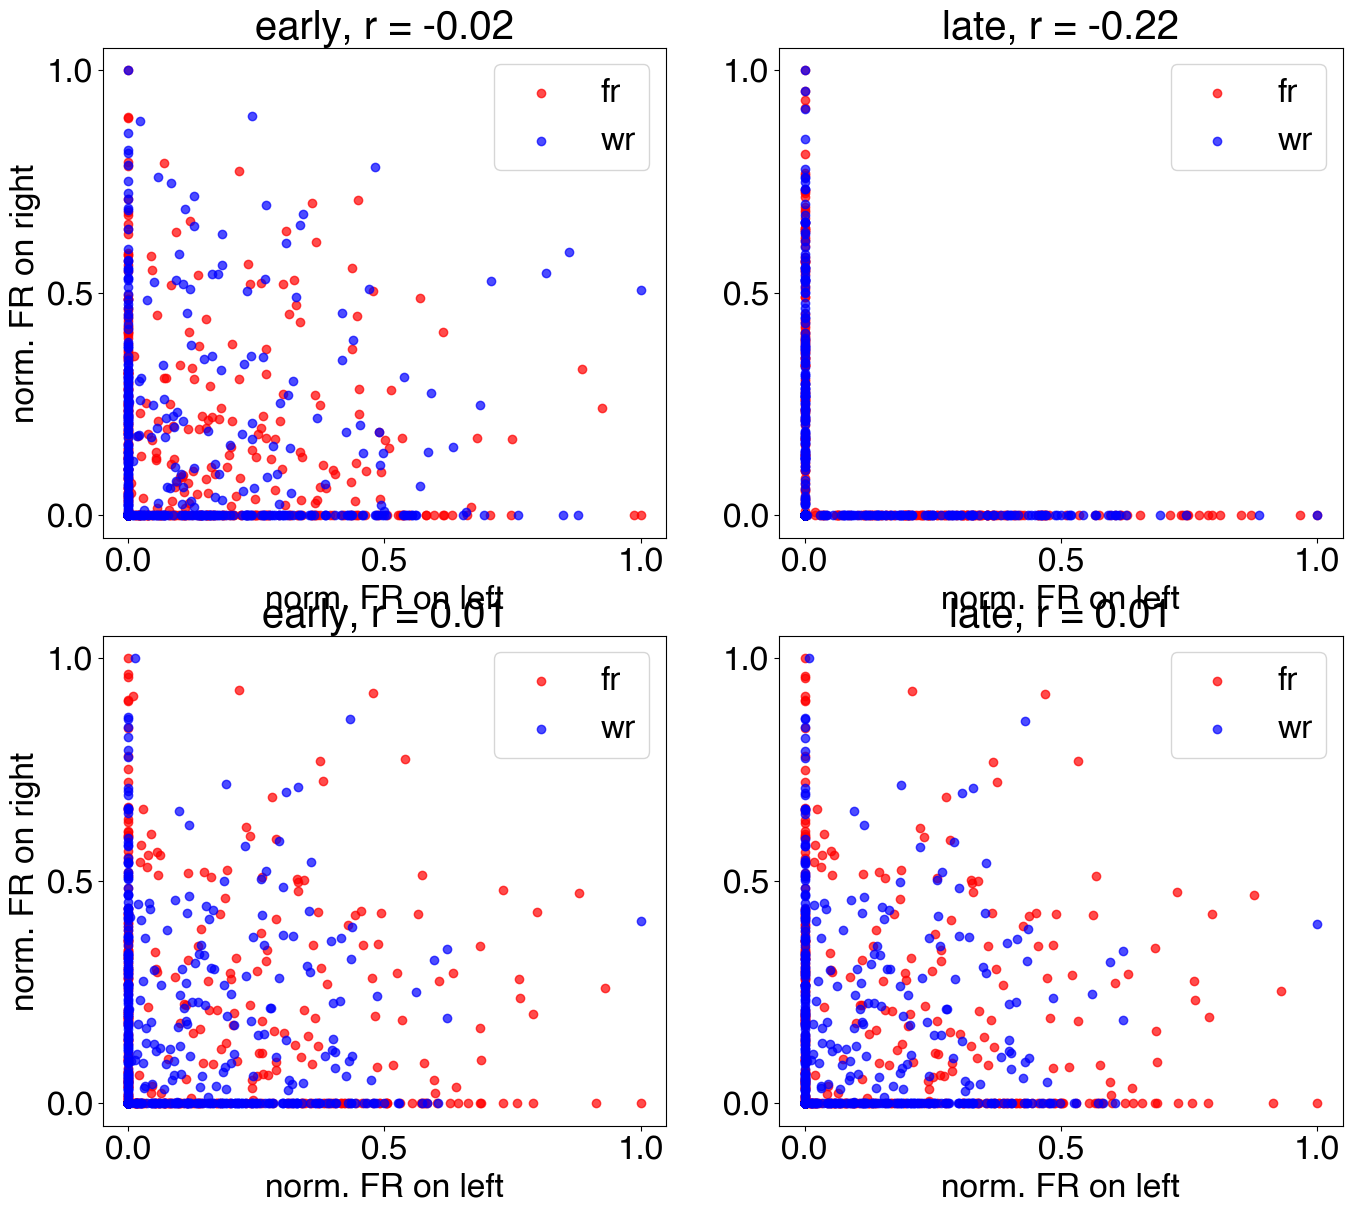

In [660]:
context_labels = ['fr', 'wr']
context_colors = ['red', 'blue']
arm_labels = ['left', 'right'] 
context_idx = [[1, 3], [0, 2]]

norm_hidden = np.zeros((4, 4, dim_hidden))

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 14)
for m_i, model in enumerate(rich_models + lazy_models):
    axis = axes.flatten()[m_i]
    
    _, hiddens = model(X)
    hidden_act = hiddens.detach().numpy()
    
    norm_act_all = []
    for c_i, c_label in enumerate(context_labels):
        context_X = X[context_idx[c_i]]
    
        _, hiddens = model(context_X)
        hidden_act = hiddens.detach().numpy()
        # norm_act = [stats.zscore(act) for act in hidden_act]
        norm_act = [(act - act.min()) / (act.max() - act.min()) for act in hidden_act]
        # m, b = np.polyfit(norm_act[0], norm_act[1], 1)
        norm_act_all.append(norm_act)
        
        # norm_act_diff = np.mean(np.abs(norm_act[0] - norm_act[1]))
        # axis.hist(norm_act[0] - norm_act[1], label=c_label)
        # axis.set_xlabel('FR diff. between L and R')
        # axis.set_ylabel('count')
        # axis.legend()
        
        norm_hidden[m_i, context_idx[c_i], :] = norm_act
        
        axis.scatter(norm_act[0], norm_act[1], color=context_colors[c_i], alpha=0.7, label=c_label)
        
    norm_act_all_concat = np.concatenate(norm_act_all, 1)
    corr = stats.pearsonr(norm_act_all_concat[0], norm_act_all_concat[1]).statistic
    
    axis.set_xticks([0, 0.5, 1])
    axis.set_yticks([0, 0.5, 1])
    axis.set_xlabel('norm. FR on left')
    if m_i % 2 == 0:
        axis.set_ylabel('norm. FR on right')
    axis.legend()

    if m_i % 2 == 0:
        axis.set_title(f'early, r = {corr:.2f}')
    else:
        axis.set_title(f'late, r = {corr:.2f}')
            
# fig.savefig("rich_lazy_splitting.svg")

[[0.         5.79802158 6.66079982 6.43651435]
 [5.79802158 0.         6.28099339 6.04260134]
 [6.66079982 6.28099339 0.         6.87472615]
 [6.43651435 6.04260134 6.87472615 0.        ]]


Text(0.5, 0.92, 'dist(L, R) = 6.35')

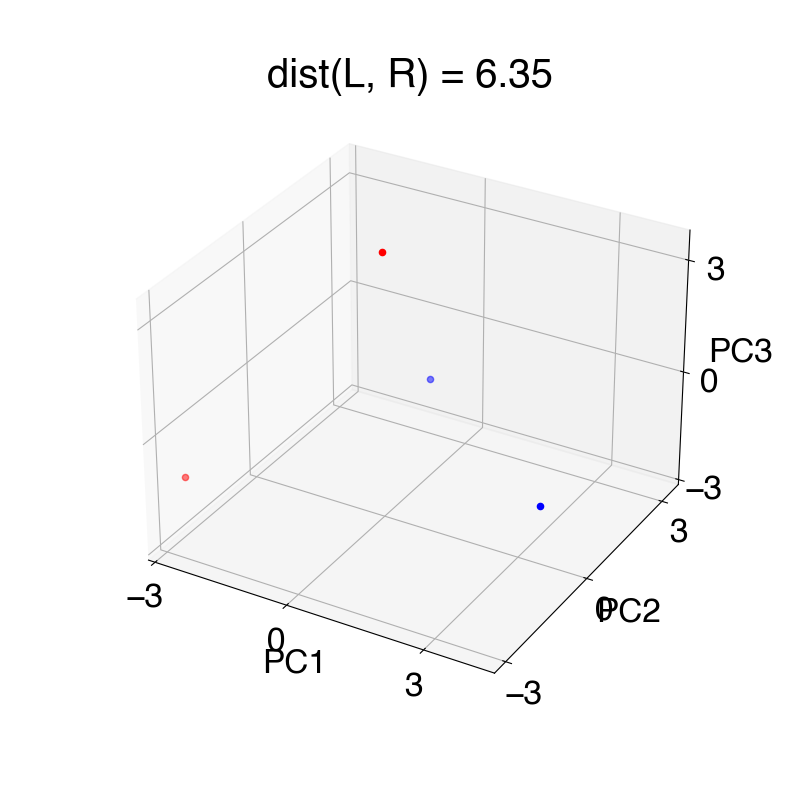

In [561]:
# %matplotlib inline
%matplotlib ipympl

# rich_trained_model = rich_models[-1]
# _, hiddens = rich_trained_model(X)
# hidden_act = hiddens.detach().numpy()

rich_norm_hidden = norm_hidden[1]

# scaler = StandardScaler()
# rich_norm_hidden = scaler.fit_transform(rich_norm_hidden)

pca = PCA(n_components=3)
rich_embed_hidden = pca.fit_transform(rich_norm_hidden)

rich_pairwise_pca = pairwise_distances(rich_embed_hidden, metric='euclidean')
print(rich_pairwise_pca)
rich_dist_LR = np.mean([rich_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot(111, projection='3d')

for l_i in range(4):
    color = 'blue' if l_i % 2 == 0 else 'red'
    alpha = 0.5 if l_i == 0 or l_i == 3 else 1
    ax.scatter(rich_embed_hidden[l_i, 0], rich_embed_hidden[l_i, 1], rich_embed_hidden[l_i, 2], c=color, alpha=alpha)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-3, 0, 3])
ax.set_zticks([-3, 0, 3])
ax.set_title(f'dist(L, R) = {rich_dist_LR:.2f}')
# plt.tick_params(left = False, right = False, bottom = False, top = False,
#                 labelleft = False, labelright = False, labelbottom = False, labeltop = False)

# mds = MDS(n_components=3, n_init=1, normalized_stress='auto')
# embed_hidden = mds.fit_transform(hidden_act)
# plt.scatter(embed_hidden[:, 0], embed_hidden[:, 1])

# labels = ['L_wr (-)', 'L_fr (+)', 'R_wr (+)', 'R_fr (-)']
# axes_tuples = [(0, 1), (0, 2), (1, 2)]

# fig, axes = plt.subplots(1, 3)
# fig.set_size_inches(18, 6)

# for a_i, axis in enumerate(axes):
#     x_axis, y_axis = axes_tuples[a_i]
#     for l_i, label in enumerate(labels):
#         color = 'blue' if l_i % 2 == 0 else 'red'
#         alpha = 0.5 if l_i == 0 or l_i == 3 else 1
#         axis.scatter(embed_hidden[l_i, x_axis], embed_hidden[l_i, y_axis], c=color, alpha=alpha)
# plt.show()

In [542]:
# fig.savefig("rich_embedding.svg")

[[0.         6.12223891 5.83864717 7.284304  ]
 [6.12223891 0.         6.91232994 5.88475866]
 [5.83864717 6.91232994 0.         5.81942575]
 [7.284304   5.88475866 5.81942575 0.        ]]


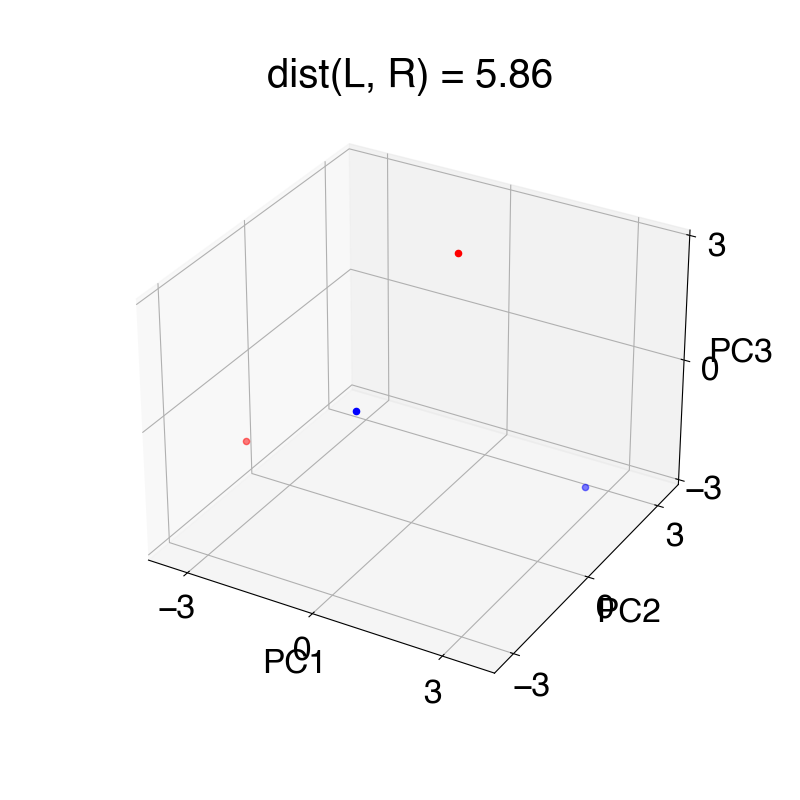

In [560]:
# %matplotlib inline
%matplotlib ipympl

# lazy_trained_model = lazy_models[-1]
# _, hiddens = lazy_trained_model(X)
# hidden_act = hiddens.detach().numpy()

# scaler = StandardScaler()
# hidden_scaled = scaler.fit_transform(hidden_act)

lazy_norm_hidden = norm_hidden[3]

# scaler = StandardScaler()
# lazy_norm_hidden = scaler.fit_transform(lazy_norm_hidden)

pca = PCA(n_components=3)
lazy_embed_hidden = pca.fit_transform(lazy_norm_hidden)

lazy_pairwise_pca = pairwise_distances(lazy_embed_hidden, metric='euclidean')
print(lazy_pairwise_pca)
lazy_dist_LR = np.mean([lazy_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])


fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot(111, projection='3d')

for l_i in range(4):
    color = 'blue' if l_i % 2 == 0 else 'red'
    alpha = 0.5 if l_i == 0 or l_i == 3 else 1
    ax.scatter(lazy_embed_hidden[l_i, 0], lazy_embed_hidden[l_i, 1], lazy_embed_hidden[l_i, 2], c=color, alpha=alpha)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-3, 0, 3])
ax.set_zticks([-3, 0, 3])
ax.set_title(f'dist(L, R) = {lazy_dist_LR:.2f}')
plt.show()

# mds = MDS(n_components=3, n_init=1, normalized_stress='auto')
# embed_hidden = mds.fit_transform(hidden_act)
# plt.scatter(embed_hidden[:, 0], embed_hidden[:, 1])

# labels = ['L_wr (-)', 'L_fr (+)', 'R_wr (+)', 'R_fr (-)']
# axes_tuples = [(0, 1), (0, 2), (1, 2)]

# fig, axes = plt.subplots(1, 3)
# fig.set_size_inches(18, 6)

# for a_i, axis in enumerate(axes):
#     x_axis, y_axis = axes_tuples[a_i]
#     for l_i, label in enumerate(labels):
#         color = 'blue' if l_i % 2 == 0 else 'red'
#         alpha = 0.5 if l_i == 0 or l_i == 3 else 1
#         axis.scatter(embed_hidden[l_i, x_axis], embed_hidden[l_i, y_axis], label=label, c=color, alpha=alpha)
# axis.legend()
# plt.show()

In [540]:
# fig.savefig("lazy_embedding.svg")